volumn&weight, quantile regression

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets
import pandas as pd
%matplotlib inline
import io
import json
import csv
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/뱀장어 평균 중량인식 공모전/data/dataset')

Mounted at /content/drive


train 폴더 124개의 각 평균면적 구하기

In [ ]:
# train 폴더목록 불러오기
folder_list = os.listdir('./train')
folder_list.sort()

#'한 영상 안에서의 뱀장어의 평균 중량' list
Area_list_video=[]
# train 폴더 내 json파일 목록 불러오기
for folder in folder_list:
  path = './train/' + folder
  train_folder_list = os.listdir(path)
  train_folder_list.sort()

  # json 파일만 불러오기
  json_file_list = [file for file in train_folder_list if file.endswith('.json')]

  dict = {}
  #'한 json파일 안의 뱀장어 n마리의 평균 중량' list
  Area_list_json=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list:
    with open((path + '/' + json_file),'r') as f:
      dict = json.load(f)
      #print(dict)

    #'한 json파일 안에서 선별된 뱀장어 각각의 중량' list
    Area_list_n = []
    for poly_num in range(len(dict['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict['data'][poly_num]['x']
      y_point = dict['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      area=PolyArea(x_point,y_point)
      Area_list_n.append(area)
    avg_area_n = sum(Area_list_n)/len(Area_list_n)
    Area_list_json.append(avg_area_n)
  avg_area_json = sum(Area_list_json)/len(Area_list_json)
  Area_list_video.append(avg_area_json)

train 124개 폴더의 평균 중량값 얻기

In [ ]:
train_csv = pd.read_csv('./train.csv')
#train_csv 정렬
train_csv=train_csv.sort_values(by='ImageDir', ascending=True)

In [ ]:
AvgWeight = train_csv.loc[:, 'AvgWeight']

In [ ]:
#volumn and Weight (m=밀도,부피 곱)
volumn_list_video=[x**1.5 for x in Area_list_video]

quantile Regression model 적용하기

산점도 그리기

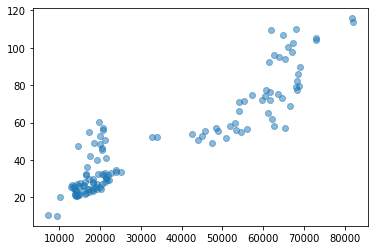

In [ ]:
Vol = torch.Tensor(volumn_list_video)
Weight = torch.Tensor(AvgWeight)
x_train = Vol  # X for model training
x_train = x_train.reshape(-1,1)
y_train = Weight   # y label

plt.scatter(x_train, y_train, alpha=0.5)

부피 히스토그램: 다봉 데이터

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


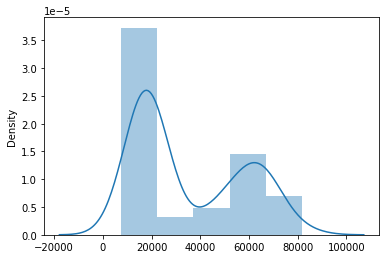

In [ ]:
import seaborn as sns
sns.distplot(volumn_list_video)

부피 박스 플랏 확인: 이상치 없음

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


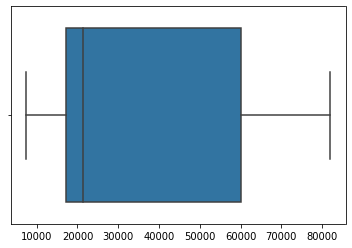

In [ ]:
sns.boxplot(volumn_list_video)

부피-중량 csv만들기

In [ ]:
data = {'Volume':volumn_list_video, 'Weight':AvgWeight}
df = pd.DataFrame(data)
csv_path = '/content/drive/MyDrive/뱀장어'
df.to_csv(csv_path+'/vol-weight.csv')

부피-중량 csv load

In [ ]:
vw_data = pd.read_csv('/content/drive/MyDrive/뱀장어/vol-weight.csv')

quantile model import

In [ ]:
import statsmodels.formula.api as smf
mod = smf.quantreg('Weight ~ Volume', vw_data)
quantiles = np.arange(.05,.96,.1) # quantiles = [.05,.15,.25,...,.95]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#'TypeError: 'dict' object is not callable' 오류 발생하는 코드.  dict=50이런 식으로 dict에 대한 값을 변수로 지정해 줬을 때 이런 오류가 난다고 함.
#https://blog.naver.com/PostView.nhn?blogId=hardhiting&logNo=222208176855
# def fit_model(q):
#   res = mod.fit(q=q)
#   return [q, res.params['Intercept'], res.params['Volume']] + \
#   res.conf_int().loc['Volume'].tolist()
  
# models = [fit_model(x) for x in quantiles]
# models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
# ols = smf.ols('Weight ~ Volume', vw_data).fit()
# ols_ci = ols.conf_int().loc['Volume'].tolist()
# ols = dict(a = ols.params['Intercept'],
#            b = ols.params['Volume'],
#            lb = ols_ci[0],
#            ub = ols_ci[1])

# print(models)
# print(ols)

In [ ]:
def fit_model(q):
  res = mod.fit(q=q)
  return [q, res.params['Intercept'], res.params['Volume']] + \
  res.conf_int().loc['Volume'].tolist()
  
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
ols = smf.ols('Weight ~ Volume', vw_data).fit()
ols_ci = ols.conf_int().loc['Volume'].tolist()
del dict
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Volume'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05   7.787263  0.000862  0.000801  0.000923
1  0.15   7.308787  0.000923  0.000853  0.000992
2  0.25   6.432466  0.001026  0.000961  0.001091
3  0.35   6.219038  0.001067  0.000994  0.001140
4  0.45   8.096564  0.001071  0.000995  0.001147
5  0.55   7.757478  0.001142  0.001058  0.001227
6  0.65   8.279164  0.001182  0.001086  0.001279
7  0.75   8.172105  0.001315  0.001201  0.001429
8  0.85  16.079441  0.001243  0.001039  0.001448
9  0.95  30.231824  0.001172  0.000914  0.001431
{'a': 10.049484785294428, 'b': 0.0011202100166338882, 'lb': 0.0010324483106652794, 'ub': 0.0012079717226024971}


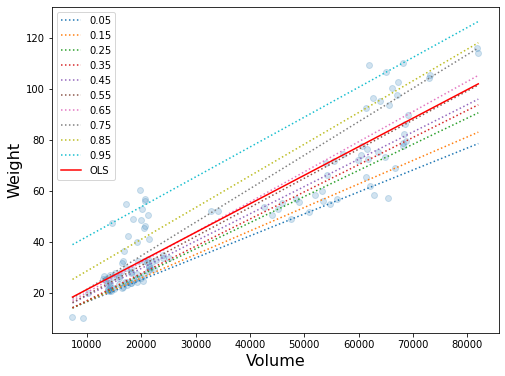

In [ ]:
x = np.arange(vw_data.Volume.min(), vw_data.Volume.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', label= str(round(0.05 + i*0.1, 2)))

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(vw_data.Volume, vw_data.Weight, alpha=.2)
legend = ax.legend()
ax.set_xlabel('Volume', fontsize=16)
ax.set_ylabel('Weight', fontsize=16);

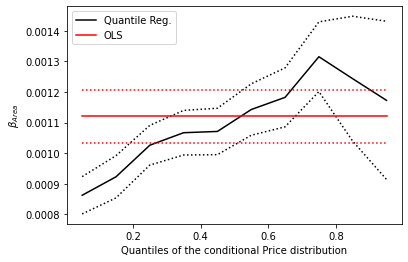

In [ ]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{Area}$')
plt.xlabel('Quantiles of the conditional Price distribution')
plt.legend()
plt.show()

x_test만들기

In [ ]:
# test 폴더목록 불러오기
folder_list_t = os.listdir('./test')
folder_list_t.sort()

#'한 영상 안에서의 뱀장어의 평균 중량' list
Area_list_video_t=[]
# test 폴더 내 json파일 목록 불러오기
for folder in folder_list_t:
  path = './test/' + folder
  test_folder_list = os.listdir(path)
  test_folder_list.sort()

  # json 파일만 불러오기
  json_file_list_t = [file for file in test_folder_list if file.endswith('.json')]

  dict_t = {}
  #'한 json파일 안의 뱀장어 n마리의 평균 중량' list
  Area_list_json_t=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list_t:
    with open((path + '/' + json_file),'r') as f:
      dict_t = json.load(f)
      #print(dict)

    #'한 json파일 안에서 선별된 뱀장어 각각의 중량' list
    Area_list_n_t = []
    for poly_num in range(len(dict_t['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict_t['data'][poly_num]['x']
      y_point = dict_t['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      area=PolyArea(x_point,y_point)
      Area_list_n_t.append(area)
    avg_area_n_t = sum(Area_list_n_t)/len(Area_list_n_t)
    Area_list_json_t.append(avg_area_n_t)
  avg_area_json_t = sum(Area_list_json_t)/len(Area_list_json_t)
  Area_list_video_t.append(avg_area_json_t)

In [ ]:
print(Area_list_video_t)
print(len(Area_list_video_t))

[662.4375370492812, 1708.7593173932387, 722.6720194970871, 663.7034483771207, 651.8044991189411, 568.8820669038878, 449.0646247493141, 1555.7210654514797, 726.4515932811953, 1618.9268529672943, 852.5906718135408, 1477.721343682583, 683.5192306434601, 1404.848888359753, 1342.6419857565306, 1724.0989784845353, 1799.156835956846, 1549.842560918113, 659.2050511774631, 648.6561225006251, 710.2440765257314, 703.7969545842535, 788.3841408263247, 1594.0854149255838, 725.183092149861, 742.4681457550467, 660.4892974873356, 1668.1238624589685, 1335.512175980922, 424.50283346379854, 398.9088482113063, 1981.4615247866811, 2017.282951770889, 672.1646101277685, 1629.9703960860122, 563.1109237578697, 1584.37277777866, 750.2532702290229, 1337.5697349176455, 619.4525751493973, 1565.5974483164375, 1067.356613563529, 779.2684541988293, 466.88742173619397, 1372.7004378427744, 750.4835997966347, 1435.9604387000663, 1714.457522921118, 1579.0697968779064, 1787.0966609367786, 609.4402469741007, 626.30569214866

In [ ]:
volumn_list_video_t=[x**1.5 for x in Area_list_video_t]

In [ ]:
volumn_list_video_t

In [ ]:
Vol_t = torch.Tensor(volumn_list_video_t)
x_test = Vol_t  # X for model training
x_test = x_test.reshape(-1,1)

예측하기

In [ ]:
data = {'Volume':volumn_list_video_t}
df = pd.DataFrame(data)
csv_path = '/content/drive/MyDrive/뱀장어'
df.to_csv(csv_path+'/vol-weight_t.csv')
vw_data_t = pd.read_csv('/content/drive/MyDrive/뱀장어/vol-weight_t.csv')

In [ ]:
predictions = get_y(ols['a'], ols['b'])

In [ ]:
predictions

array([ 18.28580265,  18.34181315,  18.39782365, ..., 101.79745939,
       101.85346989, 101.90948039])

csv파일 만들기

In [ ]:
data = {'ImageDir':folder_list_t, 'AvgWeight':predictions}
 
df = pd.DataFrame(data)
df

ValueError: ignored

In [ ]:
csv_path = '/content/drive/MyDrive/뱀장어'
df.to_csv(csv_path+'/test.csv')